In [21]:
# Data manipulation
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio

# Machine learning
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

# Optimization
import optuna
import optuna.visualization as vis

# System utilities
import os
from PIL import Image
import joblib

In [22]:
# Calculate number of CPU cores to use (all available minus 1)
n_cores = os.cpu_count() - 1 if os.cpu_count() > 1 else 1

#lidar-based target data
lidar_path = 'data/raster/lidar_products/2019_lidar_cover.tif'

#rap data (predictor)
rap_path = 'data/raster/rap/woody_cover_2019.tif'

#static terrain predictors
dem_path = 'data/raster/ned/ned.tif'
slope_path = 'data/raster/terrain/slope.tif'
hli_path = 'data/raster/terrain/hli.tif'

#train sample locations
train_points_path = 'data/vector/train_points_with_folds.geojson'

gpd_train_points = gpd.read_file(train_points_path)

results_dir = 'results/optimization'
os.makedirs(results_dir, exist_ok=True)

# Read raster data for all points first
with rasterio.open(lidar_path) as src:
    Y = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

with rasterio.open(rap_path) as src:
    rap = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

with rasterio.open(dem_path) as src:
    dem = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

with rasterio.open(slope_path) as src:
    slope = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

with rasterio.open(hli_path) as src:
    hli = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

# Create feature dataframe for all points
X = pd.DataFrame({
    'rap': rap,
    'dem': dem, 
    'slope': slope,
    'hli': hli
})

# Pre-allocate arrays for tpi and weights
tpi_values = {}
weight_values = {}

# Iterate over possible parameter values and read corresponding rasters
for ngb_val in [30, 60, 120, 240, 480, 960, 1920]:
    tpi_path = f'data/raster/terrain/tpi_{ngb_val}.tif'
    with rasterio.open(tpi_path) as src:
        tpi_values[ngb_val] = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

for exp_val in range(0, 11):
    if exp_val != 0:
        sample_weight_path = f'data/raster/wt_layers/distexp_{exp_val}.tif'
        with rasterio.open(sample_weight_path) as src:
            weight_values[exp_val] = [x[0] for x in src.sample([(p.x, p.y) for p in gpd_train_points.geometry])]

In [45]:
def objective(trial):
    params = {
        'objective': 'tweedie',
        'metric': 'mae',
        'random_state': 42,
        'n_jobs': 1,
        'verbosity': -1,
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'max_depth': trial.suggest_int('max_depth', 25, 40),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 10),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.9, 1.0),
        'tweedie_variance_power': trial.suggest_float('tweedie_variance_power', 1.4, 1.95),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-2, 1e1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-4, 1e1, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-8, 1e-6, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e1, log=True),
        'EXPVAL': trial.suggest_int('EXPVAL', 0, 10),
        'NGBVAL': trial.suggest_categorical('NGBVAL', [30, 60, 120, 240, 480, 960, 1920]),
    }

    def process_fold(fold, params, X, tpi_values, weight_values, Y, gpd_train_points):
        train_mask = gpd_train_points['fold'] != fold
        test_mask = (gpd_train_points['fold'] == fold) & (gpd_train_points['valid'] == True)

        # Add tpi to the feature dataframe
        X_fold = X.copy()
        X_fold['tpi'] = tpi_values[params['NGBVAL']]

        X_train = X_fold[train_mask]
        X_test = X_fold[test_mask]
        y_train = np.array(Y)[train_mask]
        y_test = np.array(Y)[test_mask]

        # Create the LightGBM model
        lgb_model = lgb.LGBMRegressor(**params)

        if params['EXPVAL'] != 0:
            weights = weight_values[params['EXPVAL']]
            sample_weights = np.array(weights)[train_mask]
            sample_weights = sample_weights / np.sum(sample_weights)
            lgb_model.set_params(sample_weight=sample_weights)

        lgb_model.fit(X_train, y_train)
        y_pred = lgb_model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        return mae

    mae_scores = joblib.Parallel(n_jobs=n_cores)(
        joblib.delayed(process_fold)(fold, params, X, tpi_values, weight_values, Y, gpd_train_points)
        for fold in range(5)
    )

    return np.mean(mae_scores)

In [47]:
def save_study_callback(study, trial):
    joblib.dump(study, os.path.join(results_dir, "study.pkl"))

    values = [t.value for t in study.trials]
    min_value = min(values) - 0.1
    max_value = 8

    fig_history = vis.plot_optimization_history(study)
    fig_history.update_yaxes(range=[min_value, max_value])  # Set y-axis range
    fig_history.write_image(os.path.join(results_dir, "optimization_history.png"))

    fig_slice = vis.plot_slice(study)
    fig_slice.update_yaxes(range=[min_value, max_value])  # Set y-axis range
    fig_slice.write_image(os.path.join(results_dir, "slice_plot.png"))

trial_count = 300

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=trial_count, callbacks=[save_study_callback])

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-01-10 00:21:48,741] A new study created in memory with name: no-name-74c9076d-1a81-432a-af0b-0cefb44bfcab
[I 2025-01-10 00:22:05,574] Trial 0 finished with value: 9.164780928444168 and parameters: {'n_estimators': 623, 'subsample': 0.9636701098051386, 'max_depth': 26, 'subsample_freq': 10, 'colsample_bytree': 0.9945347907383777, 'tweedie_variance_power': 1.683981273685177, 'learning_rate': 0.001086327267051422, 'num_leaves': 789, 'min_child_samples': 6, 'reg_alpha': 4.442098721978647, 'reg_lambda': 0.00021890145703562535, 'min_split_gain': 1.472113399590298e-07, 'min_child_weight': 0.012923318752676783, 'EXPVAL': 7, 'NGBVAL': 960}. Best is trial 0 with value: 9.164780928444168.
[I 2025-01-10 00:22:26,669] Trial 1 finished with value: 6.774086115308978 and parameters: {'n_estimators': 722, 'subsample': 0.8918789876517966, 'max_depth': 27, 'subsample_freq': 2, 'colsample_bytree': 0.9790829508242018, 'tweedie_variance_power': 1.807568610717364, 'learning_rate': 0.03274809231045089

Best trial:
  Value:  6.370212021210245
  Params: 
    n_estimators: 804
    subsample: 0.7735168106894902
    max_depth: 29
    subsample_freq: 1
    colsample_bytree: 0.9356171928311757
    tweedie_variance_power: 1.939025565866857
    learning_rate: 0.005281798549769573
    num_leaves: 734
    min_child_samples: 6
    reg_alpha: 0.020425620580573366
    reg_lambda: 0.33850210830630567
    min_split_gain: 2.483155267230504e-07
    min_child_weight: 0.14155193187046086
    EXPVAL: 9
    NGBVAL: 120


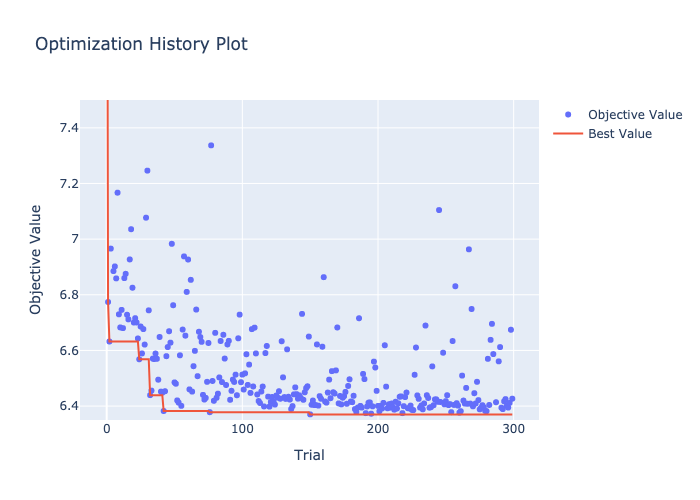

In [63]:
# Load the images
image1 = Image.open(os.path.join(results_dir, "optimization_history.png"))
image2 = Image.open(os.path.join(results_dir, "slice_plot.png"))

# Display the images side by side
image1